In [330]:
# import library
import pandas as pd
import matplotlib.pyplot as plt

# read in the data 
df = pd.read_csv('QVI_data.csv')


In [331]:
# convert the data type of "DATE" (From object to datetime)
df['DATE'] = pd.to_datetime(df['DATE'] )

In [332]:
# Revise the format of table
grouped_sales = pd.pivot_table(preTrialMeasures, values='totSales', index='STORE_NBR', columns='YEARMONTH', aggfunc='sum')
grouped_customer = pd.pivot_table(preTrialMeasures, values='nCustomers', index='STORE_NBR', columns='YEARMONTH', aggfunc='sum')

In [333]:
# Create a method to calculate the correlation 
def calculateCorrelation(inputTable, storeComparison):
	# Create an empty DataFrame to keep the calculate result
	calcCorrTable = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])

	for store_nbr, metric_col in inputTable.iterrows():
		if store_nbr != storeComparison:
			
			correlation = inputTable.loc[storeComparison].corr(metric_col)
			calculatedMeasure = pd.DataFrame({
				'Store1': [storeComparison],
				'Store2': [store_nbr],
				'corr_measure': [correlation]
			})
			calcCorrTable = pd.concat([calcCorrTable, calculatedMeasure], ignore_index=True)

	return calcCorrTable

In [334]:
# Create a method to calculate the magnitude distance
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
	
	calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
	store_numbers = input_table.index.unique()

	for store_nbr in store_numbers:
		calculated_measure = pd.DataFrame({
			'Store1': store_comparison,
			'Store2': store_nbr,
			'YEARMONTH': input_table.columns,
			'measure': abs(input_table.loc[store_comparison] - input_table.loc[store_nbr]).values
		})
		calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

	min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
	merged_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
	merged_table['magnitude_measure'] = 1 - (merged_table['measure'] - merged_table['min']) /(merged_table['max'] - merged_table['min'])
	final_dist_table = merged_table.groupby(['Store1', 'Store2']).agg({'magnitude_measure': 'mean'}).reset_index()

	return final_dist_table


In [335]:
storeComparison = 77

corr_sales = calculateCorrelation(grouped_sales, storeComparison)
corr_customer = calculateCorrelation(grouped_customer, storeComparison)

magnitude_sales = calculate_magnitude_distance(grouped_sales, 'totSales', storeComparison)
magnitude_customer = calculate_magnitude_distance(grouped_customer, 'nCustomers', storeComparison)

# Create a composite score consisting of correlation and magnitude values
corr_weight = 0.5

# merge the correlation and magnitude distance of sales
score_nSales = pd.merge(corr_sales, magnitude_sales, on=['Store1', 'Store2'])

score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['magnitude_measure'] * (1 - corr_weight)

# merge the correlation and magnitude distance of customer
score_nCustomers = pd.merge(corr_customer, magnitude_customer, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['magnitude_measure'] * (1 - corr_weight)

# merge the score 
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Choice the highest score as control store
control_store = score_Control[score_Control['Store1'] == storeComparison].sort_values(by='finalControlScore', ascending=False).iloc[0]['Store2']

print('The control_store is ' + str(control_store))

The control_store is 233


#####  The most correlated store with store 77 is store 233

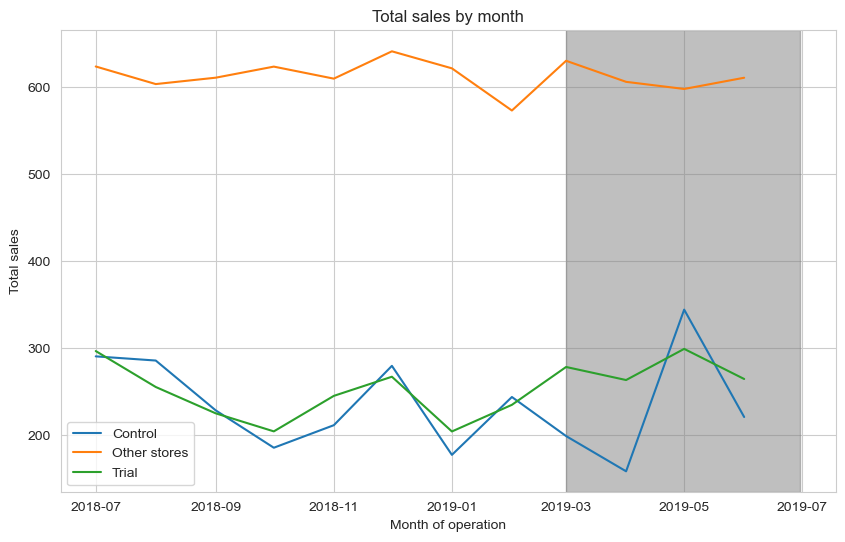

In [336]:
# Creates a new DataFrame, leaving the original DataFrame unchanged.
measureOverTimeSales = measureOverTime.copy()

# Create a new column Store_type based on specific criteria and classify each row as 'Trial', 'Control' or 'Other stores' based on the value in the STORE_NBR column.

measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)

# Convert YEARMONTH to date format
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(
	measureOverTimeSales['YEARMONTH'].astype(str), format='%Y%m'
)

pastSales = measureOverTimeSales.groupby(['TransactionMonth', 'Store_type'])['totSales'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

# The shadow area are the trial period 
plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')

plt.legend()
plt.show()


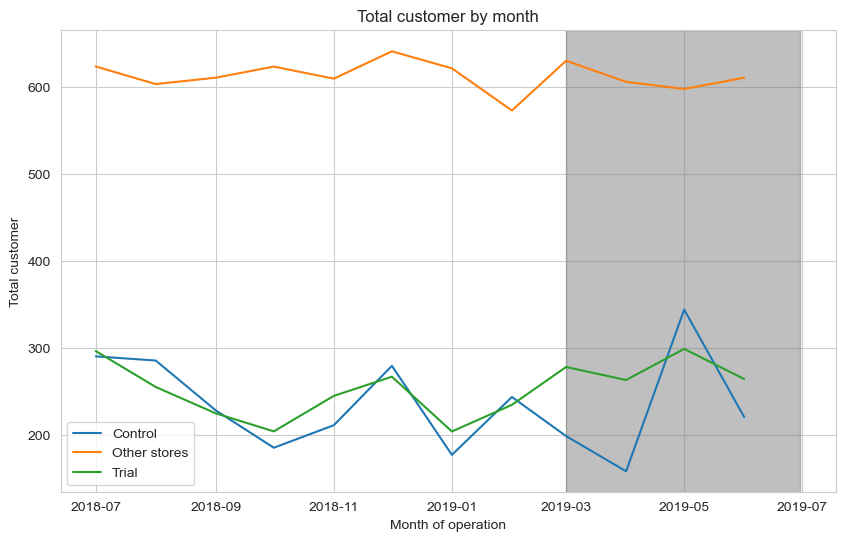

In [337]:
measureOverTimeCustomer = measureOverTime.copy()

measureOverTimeCustomer['Store_type'] = measureOverTimeCustomer['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)
measureOverTimeCustomer['TransactionMonth'] = pd.to_datetime(
	measureOverTimeCustomer['YEARMONTH'].astype(str), format='%Y%m'
)
pastCustomer = measureOverTimeCustomer.groupby(['TransactionMonth', 'Store_type'])['nCustomers'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total customer')
plt.title('Total customer by month')

plt.legend()
plt.show()

In [338]:
storeComparison = 88

corr_sales = calculateCorrelation(grouped_sales, storeComparison)
corr_customer = calculateCorrelation(grouped_customer, storeComparison)

magnitude_sales = calculate_magnitude_distance(grouped_sales, 'totSales', storeComparison)
magnitude_customer = calculate_magnitude_distance(grouped_customer, 'nCustomers', storeComparison)

corr_weight = 0.5

score_nSales = pd.merge(corr_sales, magnitude_sales, on=['Store1', 'Store2'])

score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['magnitude_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_customer, magnitude_customer, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['magnitude_measure'] * (1 - corr_weight)

score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

control_store = score_Control[score_Control['Store1'] == storeComparison].sort_values(by='finalControlScore', ascending=False).iloc[0]['Store2']

print('The control_store is ' + str(control_store))

The control_store is 237


##### The most correlated store with store 88 is store 237

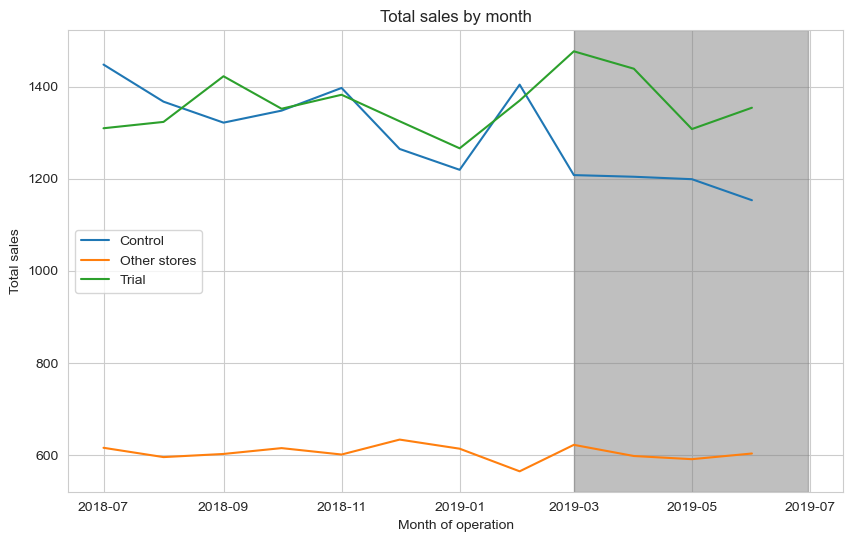

In [339]:
measureOverTimeSales = measureOverTime.copy()

measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)

measureOverTimeSales['TransactionMonth'] = pd.to_datetime(
	measureOverTimeSales['YEARMONTH'].astype(str), format='%Y%m'
)

pastSales = measureOverTimeSales.groupby(['TransactionMonth', 'Store_type'])['totSales'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')

plt.legend()
plt.show()

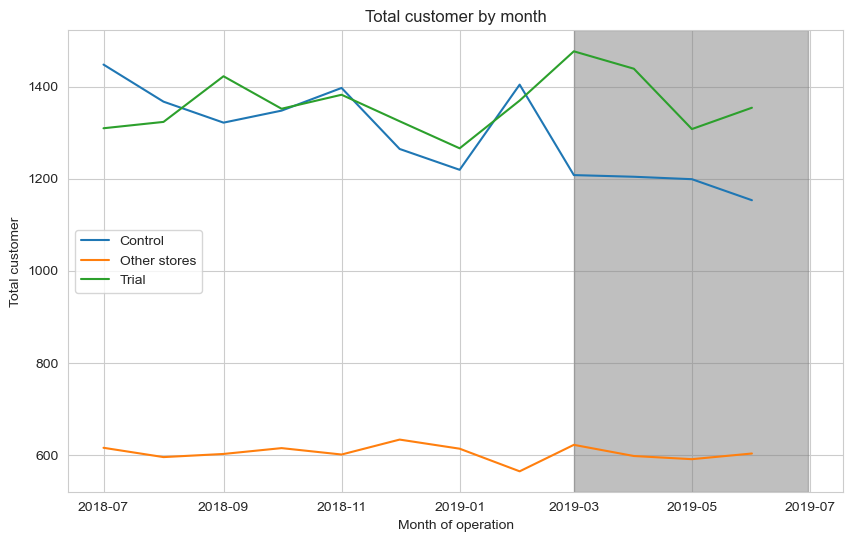

In [340]:
measureOverTimeCustomer = measureOverTime.copy()

measureOverTimeCustomer['Store_type'] = measureOverTimeCustomer['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)

measureOverTimeCustomer['TransactionMonth'] = pd.to_datetime(
	measureOverTimeCustomer['YEARMONTH'].astype(str), format='%Y%m'
)

pastCustomer = measureOverTimeCustomer.groupby(['TransactionMonth', 'Store_type'])['nCustomers'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total customer')
plt.title('Total customer by month')

plt.legend()
plt.show()

In [341]:
storeComparison = 86

corr_sales = calculateCorrelation(grouped_sales, storeComparison)
corr_customer = calculateCorrelation(grouped_customer, storeComparison)

magnitude_sales = calculate_magnitude_distance(grouped_sales, 'totSales', storeComparison)
magnitude_customer = calculate_magnitude_distance(grouped_customer, 'nCustomers', storeComparison)

corr_weight = 0.5

score_nSales = pd.merge(corr_sales, magnitude_sales, on=['Store1', 'Store2'])

score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['magnitude_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_customer, magnitude_customer, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['magnitude_measure'] * (1 - corr_weight)

score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

control_store = score_Control[score_Control['Store1'] == storeComparison].sort_values(by='finalControlScore', ascending=False).iloc[0]['Store2']

print('The control_store is ' + str(control_store))

The control_store is 155


##### The most correlated store with store 86 is store 155

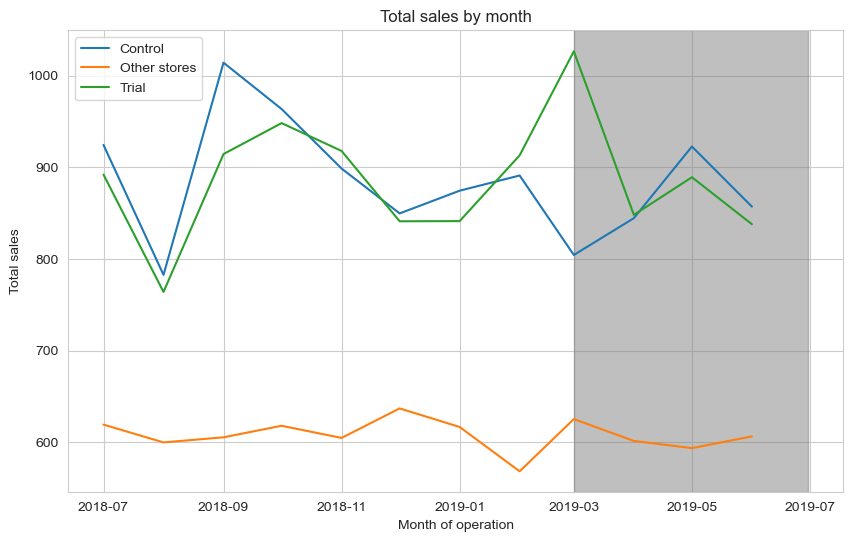

In [342]:
measureOverTimeSales = measureOverTime.copy()

measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)

measureOverTimeSales['TransactionMonth'] = pd.to_datetime(
	measureOverTimeSales['YEARMONTH'].astype(str), format='%Y%m'
)

pastSales = measureOverTimeSales.groupby(['TransactionMonth', 'Store_type'])['totSales'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')

plt.legend()
plt.show()

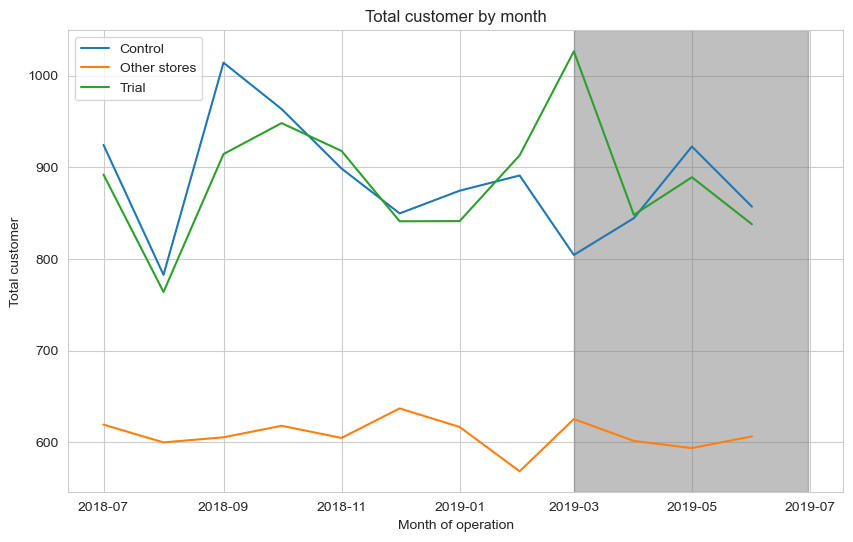

In [343]:
measureOverTimeCustomer = measureOverTime.copy()

measureOverTimeCustomer['Store_type'] = measureOverTimeCustomer['STORE_NBR'].apply(
	lambda x: 'Trial' if x == storeComparison else ('Control' if x == control_store else 'Other stores')
)

measureOverTimeCustomer['TransactionMonth'] = pd.to_datetime(
	measureOverTimeCustomer['YEARMONTH'].astype(str), format='%Y%m'
)

pastCustomer = measureOverTimeCustomer.groupby(['TransactionMonth', 'Store_type'])['nCustomers'].mean().reset_index()

plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
	plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.axvspan('2019-03-01', '2019-06-30', color='gray', alpha=0.5)

plt.xlabel('Month of operation')
plt.ylabel('Total customer')
plt.title('Total customer by month')

plt.legend()
plt.show()

#
Explanation of the control store vs other stores in the trial period (The trial period goes from the start of March 2019 to June 2019.
* The most correlated store with trail store 77 is store 233
* The most correlated store with trail store 86 is store 155
* The most correlated store with trail store 88 is store 237

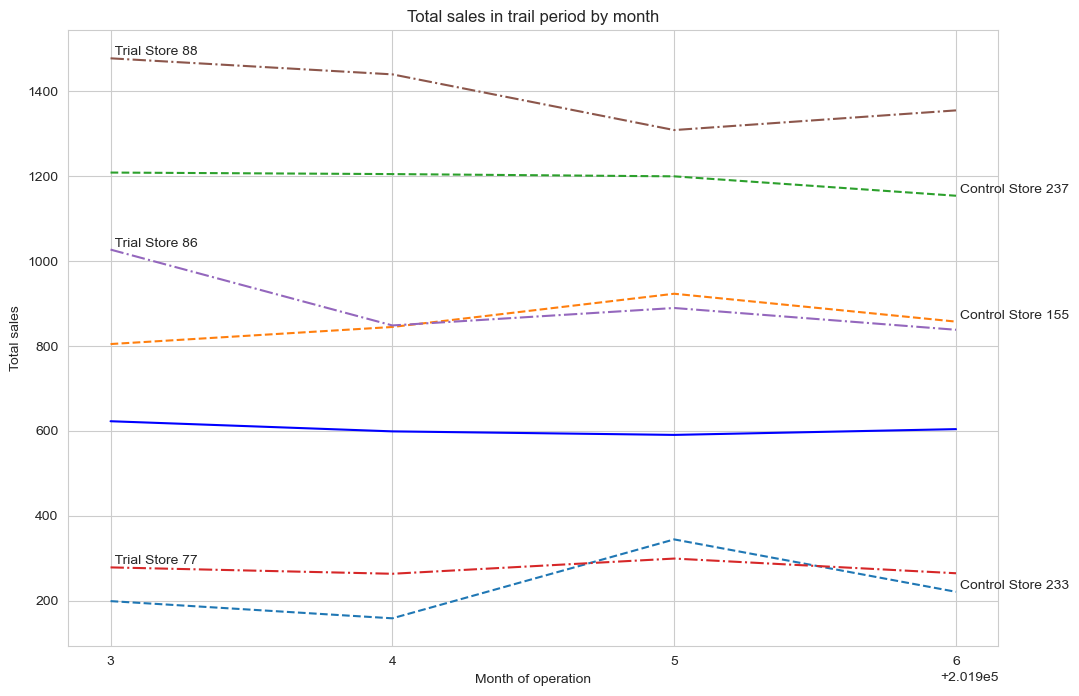

In [344]:
plt.figure(figsize=(12, 8))

# Fliter the data from 201903 to 201906
selected_data = measureOverTime[(measureOverTime['YEARMONTH'] >= 201903) & (measureOverTime['YEARMONTH'] <= 201906)]

# Draw the sales polyline of the control store
control_stores = [233, 155, 237]  
for store_nbr in control_stores:
	control_store_data = selected_data[(selected_data['Store_type'] == 'Control store') & (selected_data['STORE_NBR'] == store_nbr)]
	plt.plot(control_store_data['YEARMONTH'], control_store_data['totSales'], label=f'Control store {store_nbr}', linestyle='--')
	plt.text(control_store_data['YEARMONTH'].iloc[-1], control_store_data['totSales'].iloc[-1], f' Control Store {store_nbr}', fontsize=10, verticalalignment='bottom')
	
# Draw the sales polyline of the trial store
trial_stores = [77, 86, 88]  
for store_nbr in trial_stores:
	trial_store_data = selected_data[(selected_data['Store_type'] == 'Trial store') & (selected_data['STORE_NBR'] == store_nbr)]
	plt.plot(trial_store_data['YEARMONTH'], trial_store_data['totSales'], label=f'Trial store {store_nbr}', linestyle='-.')
	plt.text(trial_store_data['YEARMONTH'].iloc[0], trial_store_data['totSales'].iloc[0], f' Trial Store {store_nbr}', fontsize=10, verticalalignment='bottom')

# Draw the sales polyline of the other store
other_store_data = selected_data[selected_data['Store_type'] == 'Other stores']
other_store_avg = other_store_data.groupby('YEARMONTH')['totSales'].mean().reset_index()
plt.plot(other_store_avg['YEARMONTH'], other_store_avg['totSales'], label='Other stores', color='blue')

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales in trail period by month')

plt.xticks([201903, 201904, 201905, 201906])
plt.show()

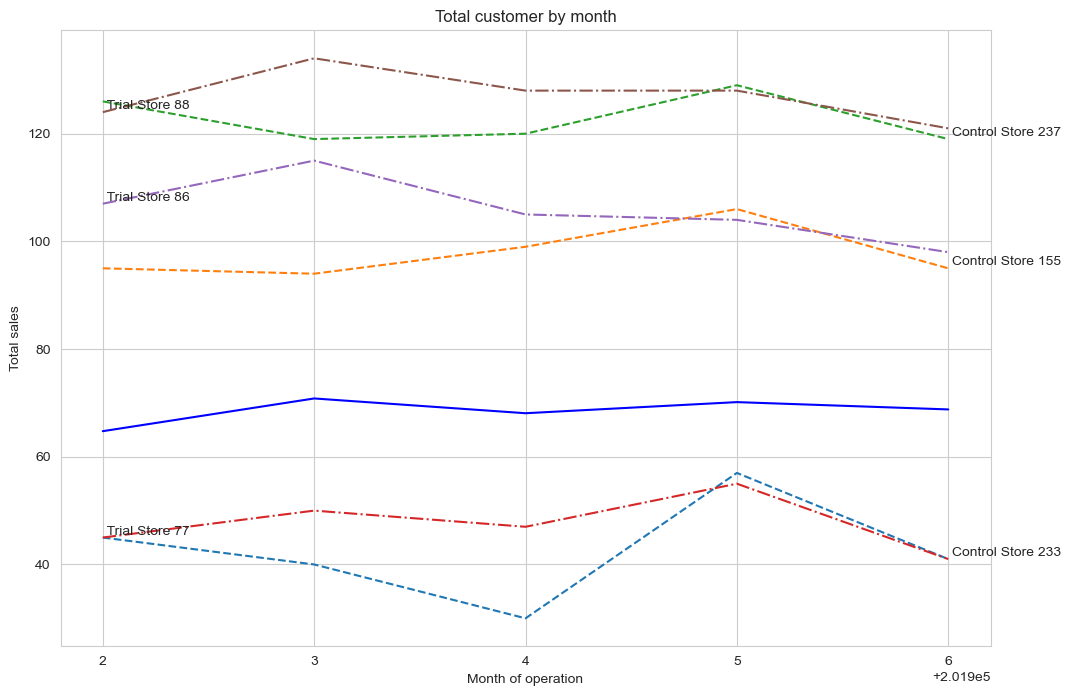

In [345]:
plt.figure(figsize=(12, 8))

selected_data = measureOverTime[(measureOverTime['YEARMONTH'] >= 201902) & (measureOverTime['YEARMONTH'] <= 201906)]

control_stores = [233, 155, 237]  
for store_nbr in control_stores:
	control_store_data = selected_data[(selected_data['Store_type'] == 'Control store') & (selected_data['STORE_NBR'] == store_nbr)]
	plt.plot(control_store_data['YEARMONTH'], control_store_data['nCustomers'], label=f'Control store {store_nbr}', linestyle='--')
	plt.text(control_store_data['YEARMONTH'].iloc[-1], control_store_data['nCustomers'].iloc[-1], f' Control Store {store_nbr}', fontsize=10, verticalalignment='bottom')

trial_stores = [77, 86, 88]  
for store_nbr in trial_stores:
	trial_store_data = selected_data[(selected_data['Store_type'] == 'Trial store') & (selected_data['STORE_NBR'] == store_nbr)]
	plt.plot(trial_store_data['YEARMONTH'], trial_store_data['nCustomers'], label=f'Trial store {store_nbr}', linestyle='-.')
	plt.text(trial_store_data['YEARMONTH'].iloc[0], trial_store_data['nCustomers'].iloc[0], f' Trial Store {store_nbr}', fontsize=10, verticalalignment='bottom')

other_store_data = selected_data[selected_data['Store_type'] == 'Other stores']
other_store_avg = other_store_data.groupby('YEARMONTH')['nCustomers'].mean().reset_index()
plt.plot(other_store_avg['YEARMONTH'], other_store_avg['nCustomers'], label='Other stores', color='blue')

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total customer by month')

plt.xticks([201902, 201903, 201904, 201905, 201906])
plt.show()